In [31]:
# obtain homemade search engine
!wget https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

--2024-10-21 22:33:16--  https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3832 (3.7K) [text/plain]
Saving to: ‘minsearch.py.6’

minsearch.py.6      100%[===================>]   3.74K  --.-KB/s    in 0s      

2024-10-21 22:33:17 (14.6 MB/s) - ‘minsearch.py.6’ saved [3832/3832]



In [32]:
# import libraries
import minsearch
import json
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
from tqdm.auto import tqdm


## Ingestion

In [33]:
# load the cleaned up json file
with open('cleaned_Data.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [34]:
# add the actual course (only one is ASU online) to the question-level info
documents = []

for id, doc in enumerate(docs_raw['documents']):
    doc['id'] = id #set up a unique id
    doc['course'] = docs_raw['course']
    documents.append(doc)

In [35]:
documents[10]

{'text': 'Textbook costs are not included in tuition.',
 'section': 'Common questions about ASU Online',
 'question': 'Are textbook costs included in tuition?',
 'id': 10,
 'course': 'ASU Online'}

In [36]:
# setup data indexing using minsearch
index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course","id"]
)

In [37]:
#actually index the data
index.fit(documents)

## RAG flow

In [38]:
# setup API key
load_dotenv('.envrc') 
openai_api_key = os.getenv('OPENAI_API_KEY')

In [39]:
# start an openAI client
client = OpenAI()

In [40]:
# set up RAG definitions
def search(query,boost=None):
    '''
    This function retrieves the top 5 results from an indexed search enging.
    We are using a homemade engine called 'minsearch' which has been
    developed by alexey grigorev.
    '''
    if boost is None:
        boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query = query,
        filter_dict={'course':'ASU Online'}, #this is a bit moo, but done for continuity
        boost_dict=boost,
        num_results=10
        )
    
    return results

def build_prompt(query,search_results):
    '''  
    This function creates an LLM friendly prompt using the results from a search engine
    as background information input.
    '''
    prompt_template = """ 
    You are a course teaching assistant. Please answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.

    QUESTION: {question}

    CONTEXT: {context}

    """.strip()

    context= ""

    # concatenate search results as one text string
    for doc in search_results:
        context = context + f'section: {doc['section']} \nquestion: {doc['question']} \nanswer: {doc['text']}\n\n'

    # fill out the prompt template
    prompt = prompt_template.format(question=query, context=context).strip()

    return prompt

def llm(prompt,model='gpt-4o-mini'):
    '''  
    This function contacts sets up the LLM model and runs the formatted prompt
    '''
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content
    


In [41]:
# set up the RAG using the 3 steps above
def rag(query,model='gpt-4o-mini',boost=None):
    ''' 
    This function generates a Retrieval-Augmented generation model architecture.
    It combines search engine retrieval results with LLM to give a user-friendly answer.
    '''
    search_results = search(query,boost=boost)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt,model=model)
    return answer

In [42]:
# try out a query
# test a search
query = 'what do I need to enroll to online graduate classes?'
answer = rag(query)

In [43]:
print(answer)

To enroll in online graduate classes at ASU, you need to complete an application process that includes submitting unofficial transcripts (later to be followed by official transcripts if accepted) and providing your junior-senior GPA if you're still finishing your undergraduate degree. You can apply while in your final year of your undergraduate program, but you should do so at least a month or two in advance of your chosen start date. After your application is processed and if accepted, you would then log in to My ASU, use your ASURITE ID and password, locate the 'Class Search', choose a subject and the online campus, and follow the enrollment steps to register for your classes.


## Retrieval Evaluation
Set up functions for retrieval evaluation metrics, and apply to ground truth data.

In [44]:
# set up functions for evaluation metrics
def hit_rate(relevance_total):
    ''' 
    This fcn evaluates hit rate
    '''
    cnt = 0
    # count if any True found on line
    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    '''
    this fcn evaluates mean reciprocal rank
    '''
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)
                break

    return total_score / len(relevance_total)


In [45]:
def evaluate(ground_truth, search_function):
    ''' 
    This function uses any specific search engine you set up to 
    check out the ground truch, and it evaluates the 2 metrics 
    '''
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['id']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [46]:
#read in data
df_question = pd.read_csv('ground_truth_data.csv')

# convert to dict
ground_truth = df_question.to_dict(orient='records')

ground_truth[0]

{'id': 0,
 'course': 'ASU Online',
 'question': 'Are the credits earned through ASU Online the same as those from on-campus classes?'}

In [47]:
# evaluate how good the search engine is depending on boosting
evaluate(ground_truth, lambda q: search(q['question'],boost={}))

  0%|          | 0/265 [00:00<?, ?it/s]

{'hit_rate': 0.7396226415094339, 'mrr': 0.4746466007786763}

### Finding the best parameters
Let us find the best parameters that maximize eval metrics

In [48]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
# if hyperopt not running do pip install --upgrade setuptools

In [49]:
# get some subset of data to validate against
df_validation = df_question[:100]
data_val = df_validation.to_dict(orient='records')

In [50]:
# Define the search space for the boosts
search_space = {
    'question_boost': hp.uniform('question_boost', 0.0, 5.0),  # Boost for 'question' between 1.0 and 5.0
    'section_boost': hp.uniform('section_boost', 0.0, 2.0)    # Boost for 'section' between 0.1 and 2.0
}

def objective(params):
    # Use the evaluate function to get hit rate and MRR for current boost values
    boost = {'question': params['question_boost'], 'section': params['section_boost']}
    
    # Call the evaluate function with the new boost values
    results = evaluate(data_val, lambda q: search(q['question'], boost=boost))
      
    # Combine hit rate and MRR for optimization
    combined_score = 0.5 * results['hit_rate'] + 0.5 * results['mrr']  # Adjust weights as needed
    
    return -combined_score


# Set up hyperopt search
trials = Trials()  # To store information about each trial

best_boost = fmin(
    fn=objective,           # Objective function to minimize
    space=search_space,      # The parameter space
    algo=tpe.suggest,        # Tree of Parzen Estimators algorithm
    max_evals=50,            # Number of trials
    trials=trials,           # To store the trials
    rstate=np.random.default_rng(42)  # Set a random seed for reproducibility
)

# Print the best boost values found by hyperopt
print("Best boost values:", best_boost)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:07,  6.81trial/s, best loss: -0.6381567460317461]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:00<00:04,  9.51trial/s, best loss: -0.845561507936508] 

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 4/50 [00:00<00:05,  8.55trial/s, best loss: -0.845561507936508]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:00<00:04,  9.48trial/s, best loss: -0.845561507936508]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:00<00:04,  9.27trial/s, best loss: -0.845561507936508]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:01<00:04,  9.89trial/s, best loss: -0.845561507936508]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [00:01<00:04,  9.35trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [00:01<00:03, 10.01trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 14/50 [00:01<00:03,  9.44trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 16/50 [00:01<00:03,  9.90trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [00:01<00:03,  9.44trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 36%|███▌      | 18/50 [00:01<00:03,  9.24trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [00:02<00:03,  8.91trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 20/50 [00:02<00:03,  8.34trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [00:02<00:03,  8.18trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [00:02<00:03,  8.58trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [00:02<00:03,  8.18trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 25/50 [00:02<00:02,  9.25trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

 52%|█████▏    | 26/50 [00:02<00:02,  8.87trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 56%|█████▌    | 28/50 [00:03<00:02,  9.80trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 60%|██████    | 30/50 [00:03<00:02,  9.63trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 64%|██████▍   | 32/50 [00:03<00:01, 10.18trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 34/50 [00:03<00:01,  9.87trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [00:03<00:01, 10.31trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [00:04<00:01,  9.75trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████  | 40/50 [00:04<00:01,  9.62trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 84%|████████▍ | 42/50 [00:04<00:00, 10.01trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [00:04<00:00,  9.79trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 92%|█████████▏| 46/50 [00:04<00:00, 10.22trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [00:05<00:00,  9.92trial/s, best loss: -0.8862559523809523]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  9.50trial/s, best loss: -0.8862559523809523]
Best boost values: {'question_boost': np.float64(0.20630178685456357), 'section_boost': np.float64(0.0694068717136398)}


In [51]:
# check final evaluation using optimized values
evaluate(ground_truth, lambda q: search(q['question'],boost={'question': 0.2, 'section': 0.07}))


  0%|          | 0/265 [00:00<?, ?it/s]

{'hit_rate': 0.9433962264150944, 'mrr': 0.7722926025756213}

## RAG evaluation
We are going to use the cosine similarity metric to evaluate the quality of our RAG flow.

In [52]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
transform_model = SentenceTransformer(model_name)

In [69]:
def process_record(rec,model='gpt-4o-mini'):
    '''
    This fcn processes the question on the record, obtains a RAG answer, and stores the 
    LLM answer, the actual answer, and other metadata per question.
    '''
    boost={'question': 0.2, 'section': 0.07}

    query = rec['question']
    answer_llm = rag(query,model=model,boost=boost)
    
    doc_id = rec['id']
    original_doc = documents[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': query,
        'course': rec['course'],
    }

In [76]:
def compute_similarity(record):
    ''' 
    This function calculates the cosine similarity metric for RAG evaluation.
    It uses a sentence transformer from huggingface to convert sentences to vectors.
    Then the vector similarity is calculated via cosines.
    '''
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = transform_model.encode(answer_llm)
    v_orig = transform_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [70]:
# test process record fcn
rec = ground_truth[10]
out = process_record(rec,model='gpt-4o-mini')
out

{'answer_llm': "In addition to submitting an application to ASU Online, the following additional steps are involved in the admission process:\n\n1. **Payment of the Application Fee**: You must pay the application fee to complete your application.\n   \n2. **Submission of Transcripts**: ASU needs to receive transcripts from every institution you've attended to complete your application. If you haven't completed an associate degree, you will also need to have your official high school transcripts sent to ASU.\n\nOnce these steps are completed, your application will be considered complete.",
 'answer_orig': "Your application is complete once you pay the application fee and ASU receives all of your required transcripts. If you haven't completed an associate degree, you'll need to have your official high school transcripts sent to us. Please have you transcripts sent to:Admission ServicesArizona State UniversityPO Box 870112Tempe, AZ 85287-0112",
 'document': 2,
 'question': 'What additiona

### GPT-4o-mini

In [72]:
# process all records using fcn
results_gpt4omini = []
for record in tqdm(ground_truth):
    result = process_record(record,model='gpt-4o-mini')
    results_gpt4omini.append(result)

  0%|          | 0/265 [00:00<?, ?it/s]

In [74]:
# save processed records
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('results-gpt4o-mini.csv', index=False)

In [77]:
# calculate cosine similarity for gpt 4o mini
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/265 [00:00<?, ?it/s]

In [78]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    265.000000
mean       0.778287
std        0.138110
min        0.222554
25%        0.695086
50%        0.803524
75%        0.879397
max        0.999493
Name: cosine, dtype: float64

### GPT-4o

In [ ]:
results_gpt4o = []

In [95]:
processed_questions = {record['question'] for record in results_gpt4o}

In [96]:
# process all records using fcn
for record in tqdm(ground_truth):
    if record['question'] in processed_questions:
        continue
    else:
        result = process_record(record,model='gpt-4o')
        results_gpt4o.append(result)

  0%|          | 0/265 [00:00<?, ?it/s]

In [97]:
# save processed records
df_gpt4o = pd.DataFrame(results_gpt4o)
df_gpt4o.to_csv('results-gpt4o.csv', index=False)

In [98]:
# calculate cosine similarity for gpt 4o mini
similarity_4o = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity_4o.append(sim)

  0%|          | 0/265 [00:00<?, ?it/s]

In [99]:
df_gpt4o['cosine'] = similarity_4o
df_gpt4o['cosine'].describe()

count    265.000000
mean       0.781747
std        0.143543
min        0.239305
25%        0.685649
50%        0.807447
75%        0.892453
max        1.000000
Name: cosine, dtype: float64

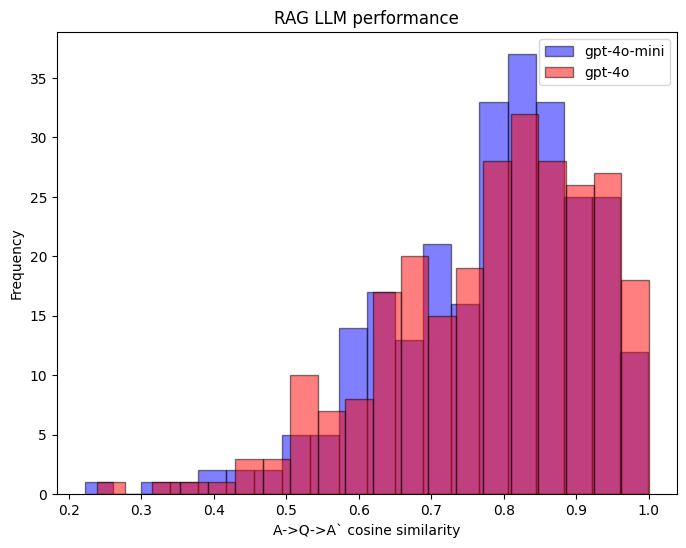

In [100]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(df_gpt4o_mini['cosine'], bins=20, alpha=0.5,label='gpt-4o-mini',color='blue', edgecolor='black')
plt.hist(df_gpt4o['cosine'], bins=20, alpha=0.5,label='gpt-4o',color='red', edgecolor='black')

# Adding labels and title
plt.xlabel('A->Q->A` cosine similarity')
plt.ylabel('Frequency')
plt.title('RAG LLM performance')

# Show the plot
plt.legend()
plt.show()

In [121]:
df_temp = df_gpt4o[df_gpt4o['cosine'] <=0.5]
df_temp.to_csv('results-badCosine-gpt4o.csv', index=False)

### NOTE
after analyzing the data to see which ones were not performing well, we found out that the last question doesnt have the correct answer on the feeding ground data. Need to correct that eventually. All else seems good.

In [122]:
f_temp

,answer_llm,answer_orig,document,question,course,cosine
37,It takes 10 working days for the student ID ca...,"Yes. Online students can order a Sun Card, ASU...",7,How long does it take to receive the student I...,ASU Online,0.440015
104,"Yes, some assignments and tests may only be av...",ASU instructors and faculty use a variety of m...,20,Will any assignments or tests have limited ava...,ASU Online,0.444146
212,"Yes, according to the FAQ database, some cours...","Typically, Arizona State University credits do...",42,Are there specific courses that may require re...,ASU Online,0.419041
213,You may need to retake courses in economics or...,"Typically, Arizona State University credits do...",42,Will I need to retake courses in economics or ...,ASU Online,0.357101
235,The context provided does not include specific...,Arizona State University offers most of its on...,47,Will I have to attend live sessions for my onl...,ASU Online,0.499428
249,The context provided does not include specific...,That depends on your specific situation and ho...,49,What is the typical duration for earning a mas...,ASU Online,0.452865
261,The FAQ database from the context does not pro...,ASU Online is dedicated to providing innovativ...,52,Is there a specific process to locate my advisor?,ASU Online,0.239305
262,The context provided does not specify details ...,ASU Online is dedicated to providing innovativ...,52,How can I contact my advisor once I find them?,ASU Online,0.467582
264,The provided context does not contain specific...,ASU Online is dedicated to providing innovativ...,52,Can I meet with my advisor virtually?,ASU Online,0.321508
